Analysis of SFO network inputs

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET


In [3]:
#net_path = '/Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/'
net_path = '/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/'


# Create lower congestion and/or lower dimensional scenarios

In [24]:
tree = ET.parse(f'{net_path}init.xml')
root = tree.getroot()

od_mat = []
for taz_elem in root.iter('tazRelation'):
    od_mat.append([taz_elem.get('from'), taz_elem.get('to'), int(taz_elem.get('count'))])


In [25]:
df_od = pd.DataFrame(od_mat, columns=['tazFrom', 'tazTo', 'tazCount'])

In [26]:
df_od.head()

,tazFrom,tazTo,tazCount
0,10100,101200,3
1,10100,10200,6
2,10100,10300,1
3,10100,10400,5
4,10100,104200,10


In [23]:
df_od.tazCount.describe()

count    620097.000000
mean          9.336738
std          27.061078
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max        2611.000000
Name: tazCount, dtype: float64

In [9]:
# check if there are duplicate taz pairs. 
df_od.shape, df_od[['tazFrom', 'tazTo']].drop_duplicates().shape

((620097, 3), (620097, 2))

In [10]:
# total OD demand 
df_od.tazCount.sum()

5789683

In [27]:
tot_sim_time_seconds = 50400.69 # obtained from init.xml

In [28]:
# demand per hour 
3600 * df_od.tazCount.sum() / tot_sim_time_seconds

413543.1241119913

In [13]:
num_hours = int(tot_sim_time_seconds/3600)
num_hours

14

In [15]:
# total demand for 14hrs (time 0 to 50400.69)
df_od.tazCount.mean()

9.33673763943383

<AxesSubplot: >

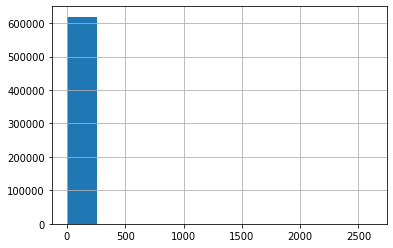

In [14]:
df_od.tazCount.hist()

In [16]:
df_od.tazCount.max(), df_od.tazCount.min()

(2611, 1)

In [31]:
# Here we consider the average demand for each OD pair among all num_hours = 14 (hrs)
# This provides us what the average number of demand is hourly for each OD pair
# Notice that we transform this average to integer

df_od['tazCount_hourly'] = [ int(elem/num_hours) for elem in df_od['tazCount'] ]

In [32]:
df_od.head()

,tazFrom,tazTo,tazCount,tazCount_hourly
0,10100,101200,3,0
1,10100,10200,6,0
2,10100,10300,1,0
3,10100,10400,5,0
4,10100,104200,10,0


In [33]:
# Total demand 
df_od['tazCount_hourly'].sum()

259799

In [35]:
# low congestion scenario, demand per hour
congestion_scaling = 5
df_od['tazCount_congLow'] = [int(elem/congestion_scaling) for elem in df_od['tazCount_hourly']]

In [36]:
df_od['tazCount_congLow'].sum()

21339

In [37]:
# before and after OD matrix sizes
# Only trips with positive demand are actually considered
df_od[df_od['tazCount_congLow']>0].shape, df_od[df_od['tazCount']>0].shape

((13058, 5), (620097, 5))

From above we see that after scaling hourly demand by a factor of 5, the
effective number of OD's went from 629,097 trips (with demand measured in seconds) to only
130,058 trips (with demand measured in hours)

In [45]:
df_od['tazCount_congLow'].sum(), df_od['tazCount'].sum()

(21339, 5789683)

Total demand also went down from 5789683 to 21339

<AxesSubplot: >

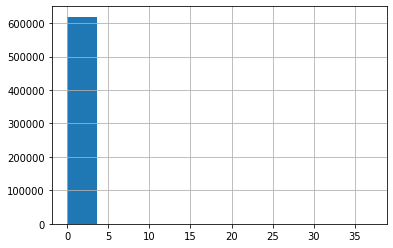

In [46]:
df_od['tazCount_congLow'].hist()

In [47]:
# Trips with at least 1000 demand
n1 = 1000
df_od[df_od['tazCount']>n1].shape, df_od[df_od['tazCount']>n1].tazCount.sum()

((24, 6), 32550)

In [48]:
# low congestion and low dimensional instance
df_od['tazCount_congLow_dimLow'] = [elem if elem > n1  else 0 for elem in df_od['tazCount']] 

In [49]:
df_od[df_od['tazCount_congLow_dimLow']>n1].shape, df_od[df_od['tazCount_congLow_dimLow']>n1].tazCount.sum()

((24, 6), 32550)

<AxesSubplot: >

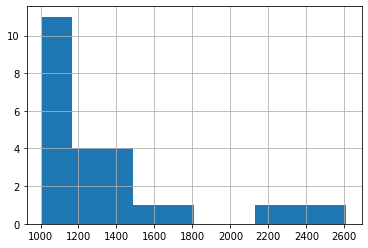

In [50]:
df_od[df_od['tazCount_congLow_dimLow']>0].tazCount_congLow_dimLow.hist()

So in general, the trick is to:
1. Convert demand from seconds to hours
2. Scale down hourly demand by a given factor. This will shift the distriution of demand to lower values across all trips and hence reduce the number of ODs with positive demand (given that we consider the floor of the scaled demand so many trips will be mapped to 0)
3. Consider only OD's with demand above a given threshold.

## Write new xml input files

In [25]:
# same average hourly demand as the initial SFO OD but now set for 1hr of simulation
tree = ET.parse(f'{net_path}init.xml')
root = tree.getroot()
    
for child in root.iter("interval"):
    child.set('end',"3600")

num_removed = 0
for interv in root.findall("interval"):
    for child in interv.findall("tazRelation"):
        #print('***', child.get('count'))
        new_demand = int(int(child.get('count'))/num_hours) # hourly demand    
        if new_demand > 0:
            child.set('count',str(new_demand))
            #print(child.get('count'))
        else:
            # remove OD
            #print('removed')
            interv.remove(child)
            num_removed += 1
            
print(num_removed)
# commented out so as to not overwrite
#tree.write(f'{net_path}initOD_1hrDemand.xml')


525236


In [26]:
# same average hourly demand as the initial SFO OD but now set for 5min of simulation
# initial xml is the above defined hourly OD (to make the xml tree parsing faster)
tree = ET.parse(f'{net_path}initOD_1hrDemand.xml')
root = tree.getroot()
    
for child in root.iter("interval"):
    child.set('end',"300") # Here we still create 1hr of total demand

num_removed = 0
for interv in root.findall("interval"):
    for child in interv.findall("tazRelation"):
        #print('***', child.get('count'))
        new_demand = int(int(child.get('count'))/12) # from hourly to 5-min demand
        if new_demand > 0:
            child.set('count',str(new_demand))
            #print(child.get('count'))
        else:
            # remove OD
            #print('removed')
            interv.remove(child)
            num_removed += 1
            
print(num_removed)
tree.write(f'{net_path}initOD_5minDemand.xml')


92084


In [30]:
# same average hourly demand as the initial SFO OD but now set for 15min of simulation
# initial xml is the above defined hourly OD (to make the xml tree parsing faster)
tree = ET.parse(f'{net_path}initOD_1hrDemand.xml')
root = tree.getroot()
    
for child in root.iter("interval"):
    child.set('end',"900")  # Here we still create 1hr of total demand

num_removed = 0
for interv in root.findall("interval"):
    for child in interv.findall("tazRelation"):
        #print('***', child.get('count'))
        new_demand = int(int(child.get('count'))/4) # from hourly to 15-min demand
        if new_demand > 0:
            child.set('count',str(new_demand))
            #print(child.get('count'))
        else:
            # remove OD
            #print('removed')
            interv.remove(child)
            num_removed += 1
            
print(num_removed)
tree.write(f'{net_path}initOD_15minDemand.xml')

76460


In [32]:
# same average hourly demand as the initial SFO OD but now set for 30min of simulation
# initial xml is the above defined hourly OD (to make the xml tree parsing faster)
tree = ET.parse(f'{net_path}initOD_1hrDemand.xml')
root = tree.getroot()
    
for child in root.iter("interval"):
    child.set('end',"1800")  # Here we still create 1hr of total demand

num_removed = 0
for interv in root.findall("interval"):
    for child in interv.findall("tazRelation"):
        #print('***', child.get('count'))
        new_demand = int(int(child.get('count'))/2) # from hourly to 30-min demand
        if new_demand > 0:
            child.set('count',str(new_demand))
            #print(child.get('count'))
        else:
            # remove OD
            #print('removed')
            interv.remove(child)
            num_removed += 1
            
print(num_removed)
tree.write(f'{net_path}initOD_30minDemand.xml')

48990


In [27]:
# lower congestion demand, 1hr of simulation
# initial xml is the above defined hourly OD (to make the xml tree parsing faster)

dem_scaling = 5
tree = ET.parse(f'{net_path}initOD_1hrDemand.xml')
root = tree.getroot()
    
for child in root.iter("interval"):
    child.set('end',"3600")

num_removed = 0
for interv in root.findall("interval"):
    for child in interv.findall("tazRelation"):
        #print('***', child.get('count'))
        new_demand = int(int(child.get('count'))/dem_scaling) 
        # still 1hr demand, but lower demand levels
        if new_demand > 0:
            child.set('count',str(new_demand))
            #print(child.get('count'))
        else:
            # remove OD
            #print('removed')
            interv.remove(child)
            num_removed += 1
            
print(num_removed)
tree.write(f'{net_path}initOD_lowCongestion_1hrDemand.xml')

81803


In [28]:
# lower congestion demand, 5min simulation
# initial xml is the above defined 1hr-low-congestion OD (to make the xml tree parsing faster)
tree = ET.parse(f'{net_path}initOD_lowCongestion_1hrDemand.xml')
root = tree.getroot()
    
for child in root.iter("interval"):
    child.set('end',"3600")

num_removed = 0
for interv in root.findall("interval"):
    for child in interv.findall("tazRelation"):
        #print('***', child.get('count'))
        new_demand = int(int(child.get('count'))/12) # from 1hr to 5min demand
        if new_demand > 0:
            child.set('count',str(new_demand))
            #print(child.get('count'))
        else:
            # remove OD
            #print('removed')
            interv.remove(child)
            num_removed += 1
            
print(num_removed)
tree.write(f'{net_path}initOD_lowCongestion_5minDemand.xml')

13016


In [26]:
import os

def run_sumo(config, prefix_run):
    od2trips_cmd = (
        #f"od2trips --no-step-log  --spread.uniform "
        f"od2trips  --spread.uniform "
        #Loads TAZ (districts)
        f"--taz-files {config['NETWORK']}/{sim_setup['taz']} " 
        # Loads O/D-matrix in tazRelation format fromFILE(s)
        f"--tazrelation-files {config['NETWORK']}/{sim_setup[f'{prefix_run}_od']} "
        # Writes trip definitions into FILE
        f"-o {config['NETWORK']}/{prefix_run}_od_trips.trips.xml " 
    )

    # Run SUMO to generate outputs
    sumo_run = (
        # Prefix which is applied to all output files. 
        f"sumo --output-prefix {prefix_run}_ " 
        # Do not check whether routes are connected
        f"--ignore-route-errors=true "
        # Load road network description from FILE
        f"--net-file={config['NETWORK']/sim_setup['net']} "
        # Load routes descriptions from FILE(s)
        f"--routes={config['NETWORK']}/{prefix_run}_od_trips.trips.xml "
        #  -b Defines the begin time in seconds; The simulation starts at this time
        # -e Defines the end time in seconds; The simulation ends at this time
        f"-b {sim_setup['start_sim_sec']} -e {sim_setup['end_sim_sec']} "
        # Load further descriptions from FILE(s)
        f"--additional-files {config['NETWORK']/sim_setup['add']} "
        f"--duration-log.statistics "
        f"--xml-validation never "
        # Save single vehicle route info into FILE
        f"--vehroutes {config['NETWORK']}/routes.vehroutes.xml "
        f"--verbose "
        # Disables output of warnings
        f"--no-warnings "
        # Faster simulation (i.e. less detailed)
        f"--mesosim true "
    
    )
        # f"--seed {seed}"

    try:
        print(od2trips_cmd)
        os.system(od2trips_cmd)
    except:
        print("Unable to create trips file")
    else:
        print("###### Running SUMO #######")
        print(sumo_run)
        os.system(sumo_run)


In [ ]:
import time
print("###### GT #######")
start = time.time() 
run_sumo(config, prefix_run = "init")
end = time.time()
print("Elapsed time: ", end - start)

print("###### Current #######")
# Current is exact copy of init.xml (i.e. GT) with this difference:
# <tazRelation from="10100" to="604400" count="5"/>  <----- Init
# <tazRelation from="10100" to="604400" count="7"/>  <----- Current
start = time.time() 
run_sumo(config, prefix_run = "current")
end = time.time()
print("Elapsed time: ", end - start)

###### GT #######
od2trips  --spread.uniform --taz-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/taz.xml --tazrelation-files /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/init.xml -o /Users/osorio/HEC/Research/Group/ExternalCollaborations/SergioRodriguez_amazon/calibrate_ods/network/SFO/init_od_trips.trips.xml 
Success.time 50390.31g time 982.65arsing time 1932.54ng time 2884.38ime 3840.554797.02.71ing time 7638.29time 8595.88 9538.8653.06me 11363.71ing time 12272.9054087.41time 14998.27rsing time 15902.10.15 17704.62g time 18605.8613.92me 21316.08ing time 22222.6204048.72time 24953.89rsing time 25867.90.96 27691.50g time 28601.8704.76me 31315.37ing time 32216.2404020.47time 34915.14rsing time 35825.07.85 37643.77g time 38552.7761.20me 41256.44ing time 42167.8773977.07time 44874.30rsing time 45790.32.48 47615.05g time 48522.78
###### Running SUMO #######
sumo --ou

In [51]:
import os
import pandas as pd
from pandas import DataFrame

def parse_loop_data_xml_to_pandas(config: dict,loop_file: dict) -> DataFrame: 
    """Read the Loop Detectors Data: Each SUMO run produces a file with the
    traffic counts. This function reads the corresponding traffic counts file
    averages across simulation replications
    
    """

    output_file =(config["NETWORK"] / "loopOutputs.csv")
    ## See output explanation:
    # https://sumo.dlr.de/docs/Simulation/Output/Lane-_or_Edge-based_Traffic_Measures.html#generated_output

    data2csv = (
        f"python {config['SUMO']}/tools/xml/xml2csv.py "
        f"{loop_file} "
        f"-o {output_file}"
        )
    
    os.system(data2csv)
    
    df_trips = pd.read_csv(output_file, sep=";", header=0)

    # edge flow in vehicles per hour
    ## edge speed is given in m/s
    ## edge_density is given in no. of vehicles/km

    df_trips['interval_nVehContrib'] = 3.6*df_trips['edge_speed']*df_trips['edge_density']

    # edge speed is given in m/s
    df_trips['interval_harmonicMeanSpeed'] = df_trips['edge_speed']
    
    df_trips['EdgeID'] = df_trips['edge_id']

    return df_trips.drop_duplicates(subset=['edge_id', 'interval_begin','interval_end'])

In [53]:
import json
from pathlib import Path
input_path = '/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/metadata'
config = json.load(open(input_path + "/config.json"))
config["NETWORK"] = Path(config["NETWORK"])
config["SUMO"] = Path(config["SUMO"])

In [ ]:
loop_stats_df_current = parse_loop_data_xml_to_pandas(
    config,
    loop_file = "../../network/SFO/current_edge_data_SFO.xml"
)

loop_stats_df_init = parse_loop_data_xml_to_pandas(
    config,
    loop_file = "../../network/SFO/init_edge_data_SFO.xml"
)

In [ ]:
import numpy as np

def compute_nrmse_counts(df_true, df_simulated):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['EdgeID', 'interval_begin', 'interval_end'],
        suffixes=('_GT', '_sim'), how='left')
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
    
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN


In [28]:
compute_nrmse_counts(loop_stats_df_init, loop_stats_df_current)

200571
200571
200424


0.4163099468304255

In [18]:
loop_stats_df_current.shape

(200424, 23)

In [19]:
loop_stats_df_current.head()

,interval_begin,interval_end,interval_id,edge_arrived,edge_density,edge_departed,edge_entered,edge_id,edge_laneChangedFrom,edge_laneChangedTo,...,edge_overlapTraveltime,edge_sampledSeconds,edge_speed,edge_speedRelative,edge_timeLoss,edge_traveltime,edge_waitingTime,interval_nVehContrib,interval_harmonicMeanSpeed,EdgeID
0,14400.0,14700.0,dump_10,0,2.15,0,9,-100134682#0,0,0,...,11.00,95.76,13.92,1.01,0.8,10.64,0.0,107.74080,13.92,-100134682#0
1,14400.0,14700.0,dump_10,0,0.55,0,1,-100134703#0,0,0,...,14.41,13.59,6.04,0.88,0.0,13.58,0.0,11.95920,6.04,-100134703#0
2,14400.0,14700.0,dump_10,0,0.55,0,1,-100134703#1,0,0,...,14.43,13.60,6.04,0.88,0.0,13.60,0.0,11.95920,6.04,-100134703#1
3,14400.0,14700.0,dump_10,0,0.45,1,0,-100267303,0,0,...,4.60,3.92,7.37,1.08,0.0,3.92,0.0,11.93940,7.37,-100267303
4,14400.0,14700.0,dump_10,0,1.38,0,6,-100400941#2,0,0,...,10.92,60.68,13.91,1.01,0.0,10.56,0.0,69.10488,13.91,-100400941#2


### Manually compute loss: departed + entered -arrived - left

In [39]:
def compute_nrmse_counts_new(df_true, df_simulated):
    # Merge simulated output with ground truth
    df_true["y"] = df_true['edge_departed'] + \
            df_true['edge_entered'] - \
            df_true['edge_arrived'] - \
            df_true['edge_left'] 

    df_simulated["y"] = df_simulated['edge_departed'] + \
            df_simulated['edge_entered'] - \
            df_simulated['edge_arrived'] - \
            df_simulated['edge_left']         

    df1 = df_true\
        .merge(df_simulated, on=['EdgeID', 'interval_begin', 'interval_end'],
        suffixes=('_GT', '_sim'), how='left')
    
    df1['y_sim'] = df1['y_sim'].fillna(0)            
    
    df1['diff_square'] = (
        df1['y_GT'] - df1['y_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN


In [40]:
compute_nrmse_counts_new(loop_stats_df_init, loop_stats_df_current)


200571
200571
200424


0.011312367053198177